# TODO

- [x] Analisar missing data e eventualmente coletar dados de outras fontes para preencher os gaps
- [x] Iniciar o front-end
- [x] Coletar recomendações de diferentes sites
- [x] Mostrar indicadores fundamentalistas de forma intuitiva: saúde empresa etc

Corretoras: Mirae, BTG, Elite, Necton, Ativa, XP, MyCap e Terra Investimentos

- [x] Terminar crawler de recomendação
- [x] Adicionar recomendações no front

- [x] Mudar recomendações para página inicial
- [ ] Testes estatísticos para ver indicadores que mais influenciam na variação de preço
- [ ] Mostrar variações (maiores/menores) de acordo com a média móvel na tela inicial
- [ ] Fazer os gráficos de acordo com natureza do indicador (possivelmente um histograma tipo sono do mi fit)
- [ ] Começar a escrever os fundamentos

In [31]:
import numpy as np
import pandas as pd
import os
from scipy import stats
import requests
import seaborn as sns
from tqdm.notebook import tqdm
from multiprocessing import Pool 

#### Funções de auxílio para buscar possíveis dados faltantes no Fundamentus

In [9]:
from bs4 import BeautifulSoup

url = "https://fundamentus.com.br/detalhes.php"


payload = ""
headers = {
    'cookie': "__cfduid=d84796ca16170a58f296efed0cf24514a1611513340; PHPSESSID=1044771291df37ab455394de9468bf58; __utmc=138951332; __utmz=138951332.1611513342.1.1.utmcsr=google|utmccn=(organic)|utmcmd=organic|utmctr=(not%20provided); _qn=1; __utma=138951332.1388485926.1611513342.1613935152.1613937167.8; __utmt=1; __cf_bm=371a925b55141fc066db8b9094462ebb88bc95cd-1613937167-1800-ASEXqmIY6lwBXCJYhwc6nhoPzGDhpgbwUSJOO+lMPDmxXUfvzKwp0s4AplpXvLl+fjlBLq9K39kO+eycZLUQL9y+jtP3k0kzPoxQfOt1Aq4aNBlYf6u8iPyGMzqaBM6YSA==; __utmb=138951332.4.10.1613937167",
    'authority': "fundamentus.com.br",
    'cache-control': "max-age=0",
    'upgrade-insecure-requests': "1",
    'user-agent': "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.182 Safari/537.36",
    'accept': "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9",
    'sec-fetch-site': "none",
    'sec-fetch-mode': "navigate",
    'sec-fetch-user': "?1",
    'sec-fetch-dest': "document",
    'accept-language': "pt-BR,pt;q=0.9,en-US;q=0.8,en;q=0.7"
}


def deepest(root, tag):
    descendant = root.find(tag)
    if descendant:
        return deepest(descendant, tag)
    return root


def br_to_us_num(num):
    if num.strip() == '-':
        num = '0'
    clean = num.replace('.', '').replace(',', '.').replace('%', '').strip()
    return float(clean)


def get_missing_data(ticker: str, missing: [str]):

    map_fields = {
        'CAGR RECEITAS 5 ANOS': 'Cres. Rec (5a)',
        'ROIC': 'ROIC',
        'LIQ CORRENTE': 'Liquidez Corr',
        'P/CAP GIRO': 'P/Cap. Giro',
        'PSR': 'PSR',
    }

    querystring = {"papel": ticker}
    response = requests.get(url,
                            data=payload,
                            headers=headers,
                            params=querystring)

    soup = BeautifulSoup(response.text)

    ziped = list(zip(soup.find_all('td', 'label'),
                     soup.find_all('td', 'data')))

    res = dict()
    for m in missing:
        if m == 'DIV LIQ/PATRI':
            div_liq, pat_liq = None, None
            for z in ziped:
                if z[0].find(text='Dív. Líquida'):
                    div_liq = br_to_us_num(deepest(z[1], 'span').text)
                elif z[0].find(text='Patrim. Líq'):
                    pat_liq = br_to_us_num(deepest(z[1], 'span').text)
            if div_liq is None or pat_liq is None:
                continue
            if pat_liq == 0:
                res[m] = 0
            else:
                res[m] = div_liq/pat_liq
        else:
            for z in ziped:
                if map_fields.get(m) is None:
                    res[m] = np.nan
                    break
                if z[0].find(text=map_fields[m]):
                    res[m] = br_to_us_num(deepest(z[1], 'span').text)
                    break
    return res

# Coleta de Dados

In [10]:
data_prefix = '../b3_fundamentals/data'
statusinvest_prefix = os.path.abspath(data_prefix + '/statusinvest')
yahoofinance_prefix = os.path.abspath(data_prefix + '/yahoofinance')

In [11]:
statusinvest_csv = statusinvest_prefix + '/' + os.listdir(statusinvest_prefix)[-1]

In [12]:
df = pd.read_csv(statusinvest_csv, index_col='TICKER')
df.columns = [col.strip().replace(' / ', '/') for col in df.columns]
df.head()

,PRECO,DY,P/L,P/VP,P/ATIVOS,MARGEM BRUTA,MARGEM EBIT,MARG LIQUIDA,P/EBIT,EV/EBIT,...,PASSIVOS/ATIVOS,GIRO ATIVOS,CAGR RECEITAS 5 ANOS,CAGR LUCROS 5 ANOS,LIQUIDEZ MEDIA DIARIA,VPA,LPA,PEG Ratio,VALOR DE MERCADO,SETOR
TICKER,,,,,,,,,,,,,,,,,,,,,
AALR3,9.01,0.97,-10.92,0.87,0.42,17.80,-0.98,-10.49,-116.57,-178.99,...,0.52,0.37,5.83,NaN,5.864217e+06,10.34,-0.82,0.03,1.068184e+09,SAÚDE
ABCB4,15.13,3.28,10.38,0.78,0.08,1.96,-1.80,5.46,-31.48,-31.37,...,0.90,0.14,21.38,-3.68,1.362790e+07,19.41,1.46,-0.29,3.331034e+09,FINANCEIRO E OUTROS
ABEV3,15.59,3.15,21.53,3.26,1.96,53.64,27.29,19.49,15.38,14.49,...,0.40,0.47,4.56,-1.85,3.901458e+08,4.78,0.72,-6.33,2.448384e+11,CONSUMO NÃO CÍCLICO
ADHM3,1.56,NaN,-4.09,-1.29,105.12,100.00,-13548.48,-18860.61,-5.69,-5.69,...,82.72,0.14,NaN,NaN,9.420144e+04,-1.21,-0.38,-0.58,2.543977e+07,SAÚDE
AERI3,9.41,NaN,63.96,7.49,3.05,11.13,9.30,5.13,35.24,37.40,...,0.59,0.93,NaN,NaN,5.683641e+07,1.26,0.15,2.32,7.225393e+09,BENS INDUSTRIAIS


In [13]:
# pega os arquivos com os dados históricos de cada ação
yf_files = os.listdir(yahoofinance_prefix)

closes = dict(var1y_6m={}, var6m_1d={})

def variation(prev, curr):
    if np.isnan(prev) or np.isnan(curr):
        return np.nan
    var = curr/prev - 1
    
    if var > .20:
        return 2
    elif var > .10:
        return 1
    elif var > -.1:
        return -1
    else:
        return -2

dfs_tickers = dict()
for ticker in list(df.index):
    ms = list(filter(lambda x: ticker in x, yf_files))
    if len(ms) == 0:
        continue
    try:
        dfs_tickers[ticker] = pd.read_csv(f'{yahoofinance_prefix}/{ms[0]}', index_col='Date')
    except Exception as e:
        print(ticker)
        raise e
    
max_days = max(map(lambda x: len(x), dfs_tickers.values()))
print(f'max days: {max_days}')

for ticker, df_ticker in dfs_tickers.items():
    df_ticker.dropna(inplace=True)

    # retira ações que não tem 1 ano completo na bolsa
    if len(df_ticker) < max_days * .95:
        continue

    middle = int(len(df_ticker)/2)
    y1mean = df_ticker['Adj Close'].iloc[:10].mean()
    m6mean = df_ticker['Adj Close'].iloc[middle-5:middle+5].mean()
    d1mean = df_ticker['Adj Close'].iloc[-10:].mean()


    closes['var1y_6m'][ticker] = variation(y1mean, m6mean)
    closes['var6m_1d'][ticker] = variation(m6mean, d1mean)

max days: 253


In [14]:
yahoofinance_prefix

'/home/adilson/Documentos/CIn/TrabalhoGraduacao/b3_fundamentals/b3_fundamentals/data/yahoofinance'

In [15]:
y = pd.DataFrame(closes)
print(len(y))
y.dropna(inplace=True)
print(len(y))
y.head()

444
444


,var1y_6m,var6m_1d
AALR3,1,-2
ABCB4,-1,1
ABEV3,-1,2
ADHM3,2,-2
AFLT3,2,-1


In [16]:
y.loc['BIDI11']

var1y_6m    2
var6m_1d    2
Name: BIDI11, dtype: int64

In [17]:
X = df.copy()
print(X.shape)
diffXy = set(X.index) ^ set(y.index)
X.drop(diffXy, inplace=True)
# y.drop(diffXy, inplace=True)
print(X.shape)
all(X.index == y.index)

(564, 30)
(444, 30)


True

# Definição de tipos

In [18]:
X['SETOR'] = X['SETOR'].astype('category')
X.dtypes

PRECO                     float64
DY                        float64
P/L                       float64
P/VP                      float64
P/ATIVOS                  float64
MARGEM BRUTA              float64
MARGEM EBIT               float64
MARG LIQUIDA              float64
P/EBIT                    float64
EV/EBIT                   float64
DIVIDA LIQUIDA/EBIT       float64
DIV LIQ/PATRI             float64
PSR                       float64
P/CAP GIRO                float64
P AT CIR LIQ              float64
LIQ CORRENTE              float64
ROE                       float64
ROA                       float64
ROIC                      float64
PATRIMONIO/ATIVOS         float64
PASSIVOS/ATIVOS           float64
GIRO ATIVOS               float64
CAGR RECEITAS 5 ANOS      float64
CAGR LUCROS 5 ANOS        float64
LIQUIDEZ MEDIA DIARIA     float64
VPA                       float64
LPA                       float64
PEG Ratio                 float64
VALOR DE MERCADO          float64
SETOR         

# Tratamento de dados ausentes

<AxesSubplot:>

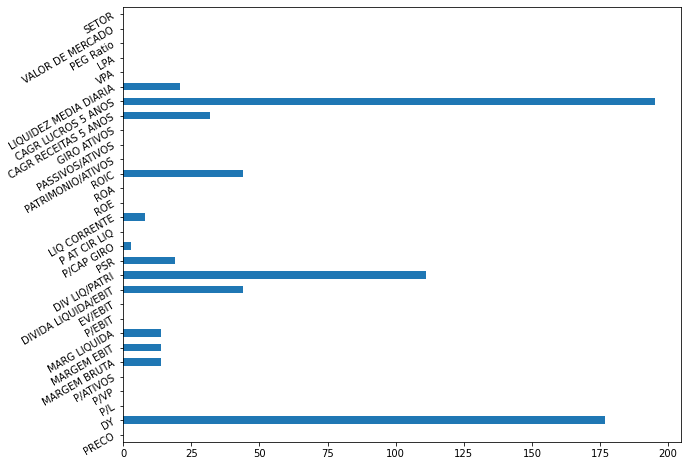

In [19]:
X.isna().sum().plot.barh(rot=30, figsize=(10, 8))

Ações que não possuem liquidez é pq já não são mais negociadas

In [20]:
X[X['LIQUIDEZ MEDIA DIARIA'].isna()].index

Index(['BOBR3', 'BPHA3', 'CALI3', 'CASN4', 'COCE6', 'CORR3', 'CORR4', 'EMAE3',
       'FIGE3', 'FIGE4', 'HOOT3', 'LUXM3', 'MGEL3', 'MMAQ3', 'MMAQ4', 'MTIG3',
       'MTSA3', 'PPAR3', 'SHUL3', 'TKNO3', 'VSPT3'],
      dtype='object', name='TICKER')

In [21]:
to_drop_lq_med_dia = X[X['LIQUIDEZ MEDIA DIARIA'].isna()].index

X.drop(to_drop_lq_med_dia, inplace=True)
y.drop(to_drop_lq_med_dia, inplace=True)

In [22]:
print(len(X))
all(X.index == y.index)

423


True

No caso abaixo, nem o fundamentus nem o status invest possuem informações sobre as margens, a Receita Líquida é o denominador de cálculo dessas margens, e para esses papeis ela é zero, então a melhor solução nesse caso é **imputar zero nas margens**

In [23]:
print(all(X[X['MARG LIQUIDA'].isna()].index == X[X['MARGEM BRUTA'].isna()].index))
print(all(X[X['MARG LIQUIDA'].isna()].index == X[X['MARGEM EBIT'].isna()].index))

X[X['MARG LIQUIDA'].isna()].index

True
True


Index(['BBSE3', 'BRAP3', 'BRAP4', 'ECPR3', 'ECPR4', 'JBDU3', 'JBDU4', 'LIPR3',
       'MAPT3', 'MAPT4', 'PPLA11', 'TCNO3', 'TCNO4'],
      dtype='object', name='TICKER')

No caso de `CAGR 5 ANOS` abaixo os papéis tem menos de 5 anos de existência, não sendo possível o calculo

In [24]:
X[X['CAGR LUCROS 5 ANOS'].isna() & X['CAGR RECEITAS 5 ANOS'].isna()].index

Index(['ADHM3', 'ATOM3', 'BAHI3', 'BIOM3', 'BMGB4', 'BRAP3', 'BRAP4', 'CEAB3',
       'CNTO3', 'ECPR3', 'ECPR4', 'HAPV3', 'HBTS5', 'JBDU3', 'JBDU4', 'LIPR3',
       'LWSA3', 'MAPT3', 'MAPT4', 'MTRE3', 'NORD3', 'PPLA11', 'PRNR3', 'SMLS3',
       'TCNO3', 'TCNO4', 'VIVA3', 'VIVR3'],
      dtype='object', name='TICKER')

In [25]:
X[X['CAGR RECEITAS 5 ANOS'].isna() & (X['SETOR'] != 'FINANCEIRO E OUTROS')]['SETOR'].index

Index(['ADHM3', 'BAHI3', 'BIOM3', 'BRAP3', 'BRAP4', 'CEAB3', 'CNTO3', 'ECPR3',
       'ECPR4', 'HAPV3', 'LIPR3', 'LWSA3', 'MTRE3', 'NORD3', 'PRNR3', 'SMLS3',
       'TCNO3', 'TCNO4', 'VIVA3', 'VIVR3'],
      dtype='object', name='TICKER')

Nas duas células abaixo é possível ver que os dados ausentes em `DIVIDA LIQUIDA/EBIT` e `ROIC` pertencem somente ao setor `FINANCEIRO E OUTROS` podendo ser imputado com zeros.

In [26]:
X[X['DIVIDA LIQUIDA/EBIT'].isna()]['SETOR'].value_counts()

FINANCEIRO E OUTROS                44
BENS INDUSTRIAIS                    0
COMUNICAÇÕES                        0
CONSUMO CÍCLICO                     0
CONSUMO NÃO CÍCLICO                 0
MATERIAIS BÁSICOS                   0
PETRÓLEO. GÁS E BIOCOMBUSTÍVEIS     0
SAÚDE                               0
TECNOLOGIA DA INFORMAÇÃO            0
UTILIDADE PÚBLICA                   0
Name: SETOR, dtype: int64

In [27]:
X[X['ROIC'].isna()]['SETOR'].value_counts()

FINANCEIRO E OUTROS                44
BENS INDUSTRIAIS                    0
COMUNICAÇÕES                        0
CONSUMO CÍCLICO                     0
CONSUMO NÃO CÍCLICO                 0
MATERIAIS BÁSICOS                   0
PETRÓLEO. GÁS E BIOCOMBUSTÍVEIS     0
SAÚDE                               0
TECNOLOGIA DA INFORMAÇÃO            0
UTILIDADE PÚBLICA                   0
Name: SETOR, dtype: int64

In [28]:
X[X['LIQ CORRENTE'].isna()]

,PRECO,DY,P/L,P/VP,P/ATIVOS,MARGEM BRUTA,MARGEM EBIT,MARG LIQUIDA,P/EBIT,EV/EBIT,...,PASSIVOS/ATIVOS,GIRO ATIVOS,CAGR RECEITAS 5 ANOS,CAGR LUCROS 5 ANOS,LIQUIDEZ MEDIA DIARIA,VPA,LPA,PEG Ratio,VALOR DE MERCADO,SETOR
TICKER,,,,,,,,,,,,,,,,,,,,,
BAZA3,41.99,8.54,3.68,0.54,0.06,37.85,49.19,28.25,2.11,2.08,...,0.89,0.06,6.35,8.48,4.826900e+04,77.52,11.42,0.04,1.227343e+09,FINANCEIRO E OUTROS
BEES3,4.95,4.20,6.75,0.91,0.05,50.63,23.67,14.58,4.16,4.35,...,0.94,0.05,-6.61,8.19,2.227655e+05,5.43,0.73,0.87,1.636511e+09,FINANCEIRO E OUTROS
BEES4,5.81,3.58,7.92,1.07,0.06,50.63,23.67,14.58,4.88,4.35,...,0.94,0.05,-6.61,8.19,1.866018e+04,5.43,0.73,1.03,1.636511e+09,FINANCEIRO E OUTROS
BMGB4,5.15,3.45,7.75,0.75,0.12,72.00,3.27,10.15,24.06,24.06,...,0.84,0.16,NaN,NaN,9.092658e+06,6.91,0.67,0.20,3.063838e+09,FINANCEIRO E OUTROS
BNBR3,67.01,4.02,5.68,0.94,0.09,57.57,40.13,25.83,3.65,3.65,...,0.90,0.06,-9.48,27.23,3.130624e+04,71.46,11.80,-0.14,5.787752e+09,FINANCEIRO E OUTROS
ITUB3,25.10,1.97,13.03,1.59,0.12,57.67,3.01,10.87,47.07,49.75,...,0.92,0.09,6.04,-10.45,1.829101e+07,15.76,1.93,-0.43,2.601773e+11,FINANCEIRO E OUTROS
ITUB4,28.15,1.75,14.62,1.79,0.14,57.67,3.01,10.87,52.83,49.75,...,0.92,0.09,6.04,-10.45,1.228675e+09,15.76,1.93,-0.48,2.601773e+11,FINANCEIRO E OUTROS


In [29]:
print(X[X['DIV LIQ/PATRI'].isna()]['SETOR'].value_counts())
X[X['DIV LIQ/PATRI'].isna()]['SETOR'].index

FINANCEIRO E OUTROS                49
CONSUMO CÍCLICO                    18
BENS INDUSTRIAIS                   17
MATERIAIS BÁSICOS                  10
UTILIDADE PÚBLICA                   5
CONSUMO NÃO CÍCLICO                 4
PETRÓLEO. GÁS E BIOCOMBUSTÍVEIS     3
SAÚDE                               1
COMUNICAÇÕES                        0
TECNOLOGIA DA INFORMAÇÃO            0
Name: SETOR, dtype: int64


Index(['ABCB4', 'ADHM3', 'AZEV3', 'AZEV4', 'AZUL4', 'BAZA3', 'BBAS3', 'BBDC3',
       'BBDC4', 'BBRK3',
       ...
       'SNSY3', 'SNSY5', 'SNSY6', 'TASA3', 'TASA4', 'TEKA3', 'TEKA4', 'TXRX3',
       'TXRX4', 'VIVR3'],
      dtype='object', name='TICKER', length=107)

In [42]:
%%time
tmp_missing = []
with Pool() as pool:
    args = [(ticker, list(row[row.isna()].index)) for ticker, row in list(X.iterrows())]
    for res in pool.starmap(get_missing_data, args):
        tmp_missing.append(res)

tmp_missing = dict(zip([t for t in X.index], tmp_missing))

CPU times: user 202 ms, sys: 82.7 ms, total: 284 ms
Wall time: 26.1 s


In [44]:
sump = dict()
for ticker, v in tmp_missing.items():
    for attr, val in v.items():
        if not np.isnan(val):
            sump[attr] = sump.get(attr, 0) + 1
            X.at[ticker, attr] = val

In [45]:
sump

{'ROIC': 43,
 'DIV LIQ/PATRI': 64,
 'CAGR RECEITAS 5 ANOS': 28,
 'PSR': 17,
 'LIQ CORRENTE': 7,
 'P/CAP GIRO': 3}

In [46]:
X.drop(columns=['CAGR LUCROS 5 ANOS'], inplace=True)

In [47]:
X.fillna(value={
    'MARG LIQUIDA': 0,
    'MARGEM BRUTA': 0,
    'MARGEM EBIT': 0,
    'DY': 0,
    'DIV LIQ/PATRI': 0,
    'DIVIDA LIQUIDA/EBIT': 0
}, inplace=True)

423

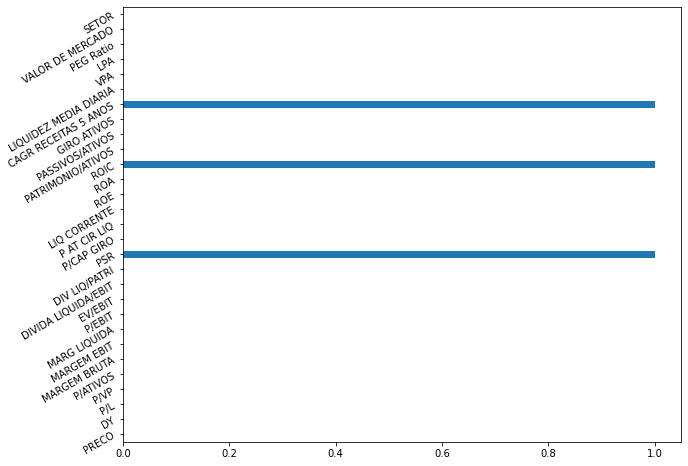

In [48]:
X.isna().sum().plot.barh(rot=30, figsize=(10, 8))
len(X)

In [49]:
tickers_nan = [idx for idx, row in X.iterrows() if row.isnull().any()]

for t in tickers_nan:
    print(f'{t} NaN:')
    print([field for field, isna in X.loc[t].isna().iteritems() if isna])
    print('-' * 100)

PPLA11 NaN:
['PSR', 'ROIC', 'CAGR RECEITAS 5 ANOS']
----------------------------------------------------------------------------------------------------


In [50]:
X.dropna(inplace=True)
y.drop(tickers_nan, inplace=True)
print(len(X))
all(X.index == y.index)

422


True

In [51]:
X.isna().sum().sum()

0

In [52]:
X.columns

Index(['PRECO', 'DY', 'P/L', 'P/VP', 'P/ATIVOS', 'MARGEM BRUTA', 'MARGEM EBIT',
       'MARG LIQUIDA', 'P/EBIT', 'EV/EBIT', 'DIVIDA LIQUIDA/EBIT',
       'DIV LIQ/PATRI', 'PSR', 'P/CAP GIRO', 'P AT CIR LIQ', 'LIQ CORRENTE',
       'ROE', 'ROA', 'ROIC', 'PATRIMONIO/ATIVOS', 'PASSIVOS/ATIVOS',
       'GIRO ATIVOS', 'CAGR RECEITAS 5 ANOS', 'LIQUIDEZ MEDIA DIARIA', 'VPA',
       'LPA', 'PEG Ratio', 'VALOR DE MERCADO', 'SETOR'],
      dtype='object')

In [53]:
y.index = y.index.rename('TICKER')
X.to_csv(f'{data_prefix}/output/X.csv')
y.to_csv(f'{data_prefix}/output/y.csv')

In [54]:
len(X) == len(y)

True